In [2]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import kagglehub

import warnings
warnings.filterwarnings('ignore')

In [510]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Création du DataFrame

In [511]:
# Download latest version
dataset_name = "Cryptos_Projects.csv"
path = kagglehub.dataset_download("mc3labs/crypto-twitter-dataset-5k-accounts-csv")
#print("Path to dataset files:", path)
dataset = pd.read_csv(path + "/" + dataset_name)

# data = pd.read_csv('/kaggle/input/crypto-twitter-dataset-5k-accounts-csv/Cryptos_Projects.csv')

df = pd.DataFrame(dataset)
print("📊 Dataset créé avec", len(df), "comptes crypto")
df.head()

📊 Dataset créé avec 7979 comptes crypto


,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1937803517265056232"": {""created_at"": ""...",Thu Aug 18 05:06:08 +0000 2011,1.0
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1937947714920300627"": {""created_at"": ""...",Sun Jan 26 19:15:24 +0000 2014,2.0
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",Fri Nov 07 21:02:30 +0000 2014,3.0
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",Mon Dec 31 19:45:39 +0000 2012,4.0
4,1052454006537314300,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",Wed Oct 17 06:59:23 +0000 2018,5.0


# Renommer favorite_count en likes_count and cast views_count to int

In [512]:
# Fonction pour renommer favorite_count en likes_count dans chaque tweet
def rename_favorite_to_likes(post_json_str):
    if pd.isna(post_json_str):
        return post_json_str
    
    # Charger le JSON
    try:
        posts_dict = json.loads(post_json_str)
    except json.JSONDecodeError:
        # Si le JSON est invalide, retourner la valeur originale
        return post_json_str
    
    # Parcourir chaque tweet dans le dictionnaire
    for _, tweet_data in posts_dict.items():
        # Vérifier si favorite_count existe
        if 'favorite_count' in tweet_data:
            # Renommer favorite_count en likes_count
            tweet_data['likes_count'] = tweet_data.pop('favorite_count')
        if 'views_count' in tweet_data:
            tweet_data['views_count'] = int(tweet_data.pop('views_count'))
    
    # Reconvertir en JSON string
    return json.dumps(posts_dict)

# Appliquer la fonction à la colonne posts
print("Début de la transformation...")
posts_before = json.loads(df.loc[0, 'posts'])
print(posts_before['tweet-1937803517265056232'].keys())
df['posts'] = df['posts'].apply(rename_favorite_to_likes)
posts_after = json.loads(df.loc[0, 'posts'])
print(posts_after['tweet-1937803517265056232'].keys())
print("Transformation terminée!")

Début de la transformation...
dict_keys(['created_at', 'full_text', 'views_count', 'bookmark_count', 'favorite_count', 'quote_count', 'reply_count', 'retweet_count', 'comments'])
dict_keys(['created_at', 'full_text', 'bookmark_count', 'quote_count', 'reply_count', 'retweet_count', 'comments', 'likes_count', 'views_count'])
Transformation terminée!


# Cast une colonne en int

In [513]:
df['market_cap_rank'] = df['market_cap_rank'].fillna(-1).astype(int)
df.head()

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1937803517265056232"": {""created_at"": ""...",Thu Aug 18 05:06:08 +0000 2011,1
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1937947714920300627"": {""created_at"": ""...",Sun Jan 26 19:15:24 +0000 2014,2
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",Fri Nov 07 21:02:30 +0000 2014,3
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",Mon Dec 31 19:45:39 +0000 2012,4
4,1052454006537314300,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",Wed Oct 17 06:59:23 +0000 2018,5


In [514]:
# Affiche le format d'un post
posts = json.loads(df.loc[0, 'posts'])
#posts['tweet-1937803517265056232']
print(len(posts))
#posts

20


In [515]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7979 entries, 0 to 7978
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                7979 non-null   int64 
 1   name              7978 non-null   object
 2   screen_name       7979 non-null   object
 3   description       7760 non-null   object
 4   is_blue_verified  7979 non-null   int64 
 5   followers_count   7979 non-null   int64 
 6   following_count   7979 non-null   int64 
 7   posts_count       7979 non-null   int64 
 8   posts             1002 non-null   object
 9   created_at        7979 non-null   object
 10  market_cap_rank   7979 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 685.8+ KB


### On supprime tout les comptes qui n'ont pas de posts/tweets

In [516]:
#df = df[df['posts'].notnull()]
df = df.dropna(subset=['posts']).reset_index(drop=True)
df.info()
df.head()
#df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1002 non-null   int64 
 1   name              1002 non-null   object
 2   screen_name       1002 non-null   object
 3   description       997 non-null    object
 4   is_blue_verified  1002 non-null   int64 
 5   followers_count   1002 non-null   int64 
 6   following_count   1002 non-null   int64 
 7   posts_count       1002 non-null   int64 
 8   posts             1002 non-null   object
 9   created_at        1002 non-null   object
 10  market_cap_rank   1002 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 86.2+ KB


,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1937803517265056232"": {""created_at"": ""...",Thu Aug 18 05:06:08 +0000 2011,1
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1937947714920300627"": {""created_at"": ""...",Sun Jan 26 19:15:24 +0000 2014,2
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",Fri Nov 07 21:02:30 +0000 2014,3
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",Mon Dec 31 19:45:39 +0000 2012,4
4,1052454006537314300,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",Wed Oct 17 06:59:23 +0000 2018,5


# Cleaning
- Supprimer les retweets/repost car pas d'informations sur les interactions (Mesure les interactions avec contenu original).
- Supprimer les tweets sans views_count mais avec interactions

In [517]:
df_filtered = df.copy()

def filter_valid_tweets(posts_json):
    posts_dict = json.loads(posts_json)
    
    filtered = {}
    for tweet_id, tweet_data in posts_dict.items():
        if (tweet_data.get('likes_count', 0) == 0 and 
            tweet_data.get('quote_count', 0) == 0 and 
            tweet_data.get('reply_count', 0) == 0) or (
                tweet_data.get('views_count', 0) == 0 and 
                (tweet_data.get('reply_count', 0) != 0 or 
                tweet_data.get('retweet_count', 0) != 0 or 
                tweet_data.get('likes_count', 0) != 0)) :
            continue
        filtered[tweet_id] = tweet_data
    
    return filtered

# Appliquer le filtre
df_filtered["filtered_posts"] = df_filtered["posts"].apply(filter_valid_tweets)
# df_filtered.drop(columns=["posts"], inplace=True)
#print(df["filtered_posts"])

posts = df_filtered.loc[0, 'filtered_posts']
# print(len(posts))
df_filtered

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,filtered_posts
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1937803517265056232"": {""created_at"": ""...",Thu Aug 18 05:06:08 +0000 2011,1,{'tweet-1937803517265056232': {'created_at': '...
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1937947714920300627"": {""created_at"": ""...",Sun Jan 26 19:15:24 +0000 2014,2,{'tweet-1935010523776430587': {'created_at': '...
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",Fri Nov 07 21:02:30 +0000 2014,3,{'tweet-1936333412077322739': {'created_at': '...
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",Mon Dec 31 19:45:39 +0000 2012,4,{'tweet-1938221710391587076': {'created_at': '...
4,1052454006537314300,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",Wed Oct 17 06:59:23 +0000 2018,5,{'tweet-1938269324575187353': {'created_at': '...
...,...,...,...,...,...,...,...,...,...,...,...,...
997,1779519551685984300,Function | FBTC,FunctionBTC,Making idle Bitcoin productive with FBTC. Back...,1,28743,16,599,"{""tweet-1937174951754395828"": {""created_at"": ""...",Sun Apr 14 14:38:40 +0000 2024,-1,{'tweet-1937174951754395828': {'created_at': '...
998,1787773163209732000,Lombard | LBTC,Lombard_Finance,"Lombard is connecting Bitcoin to every chain, ...",1,55847,337,3479,"{""tweet-1937870939552985471"": {""created_at"": ""...",Tue May 07 09:16:27 +0000 2024,-1,{'tweet-1937452368922091587': {'created_at': '...
999,1859490326316187600,G.A.M.E,GAME_Virtuals,"The Official AI Framework, Developed and Power...",1,16731,14,221,"{""tweet-1937314306150023534"": {""created_at"": ""...",Thu Nov 21 06:53:48 +0000 2024,-1,{'tweet-1937314306150023534': {'created_at': '...
1000,1869098673323344000,Trip Token,Trip_Token1,🌍 Transforming Tourism with Blockchain & DeFi ...,0,636,2,58,"{""tweet-1938072641698726296"": {""created_at"": ""...",Tue Dec 17 19:13:56 +0000 2024,-1,{'tweet-1938072641698726296': {'created_at': '...


In [518]:
# Calculer le nombre de tweets dans chaque entrée de posts
tweet_counts_original = df_filtered['posts'].apply(lambda x: len(json.loads(x)))
tweet_counts_filtered = df_filtered['filtered_posts'].apply(lambda x: len(x))

df_filtered['tweet_counts_original'] = tweet_counts_original
df_filtered['tweet_counts_filtered'] = tweet_counts_filtered
df_filtered

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,filtered_posts,tweet_counts_original,tweet_counts_filtered
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1937803517265056232"": {""created_at"": ""...",Thu Aug 18 05:06:08 +0000 2011,1,{'tweet-1937803517265056232': {'created_at': '...,20,17
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1937947714920300627"": {""created_at"": ""...",Sun Jan 26 19:15:24 +0000 2014,2,{'tweet-1935010523776430587': {'created_at': '...,20,4
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",Fri Nov 07 21:02:30 +0000 2014,3,{'tweet-1936333412077322739': {'created_at': '...,20,5
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",Mon Dec 31 19:45:39 +0000 2012,4,{'tweet-1938221710391587076': {'created_at': '...,20,6
4,1052454006537314300,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",Wed Oct 17 06:59:23 +0000 2018,5,{'tweet-1938269324575187353': {'created_at': '...,13,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,1779519551685984300,Function | FBTC,FunctionBTC,Making idle Bitcoin productive with FBTC. Back...,1,28743,16,599,"{""tweet-1937174951754395828"": {""created_at"": ""...",Sun Apr 14 14:38:40 +0000 2024,-1,{'tweet-1937174951754395828': {'created_at': '...,9,4
998,1787773163209732000,Lombard | LBTC,Lombard_Finance,"Lombard is connecting Bitcoin to every chain, ...",1,55847,337,3479,"{""tweet-1937870939552985471"": {""created_at"": ""...",Tue May 07 09:16:27 +0000 2024,-1,{'tweet-1937452368922091587': {'created_at': '...,6,4
999,1859490326316187600,G.A.M.E,GAME_Virtuals,"The Official AI Framework, Developed and Power...",1,16731,14,221,"{""tweet-1937314306150023534"": {""created_at"": ""...",Thu Nov 21 06:53:48 +0000 2024,-1,{'tweet-1937314306150023534': {'created_at': '...,20,7
1000,1869098673323344000,Trip Token,Trip_Token1,🌍 Transforming Tourism with Blockchain & DeFi ...,0,636,2,58,"{""tweet-1938072641698726296"": {""created_at"": ""...",Tue Dec 17 19:13:56 +0000 2024,-1,{'tweet-1938072641698726296': {'created_at': '...,20,20


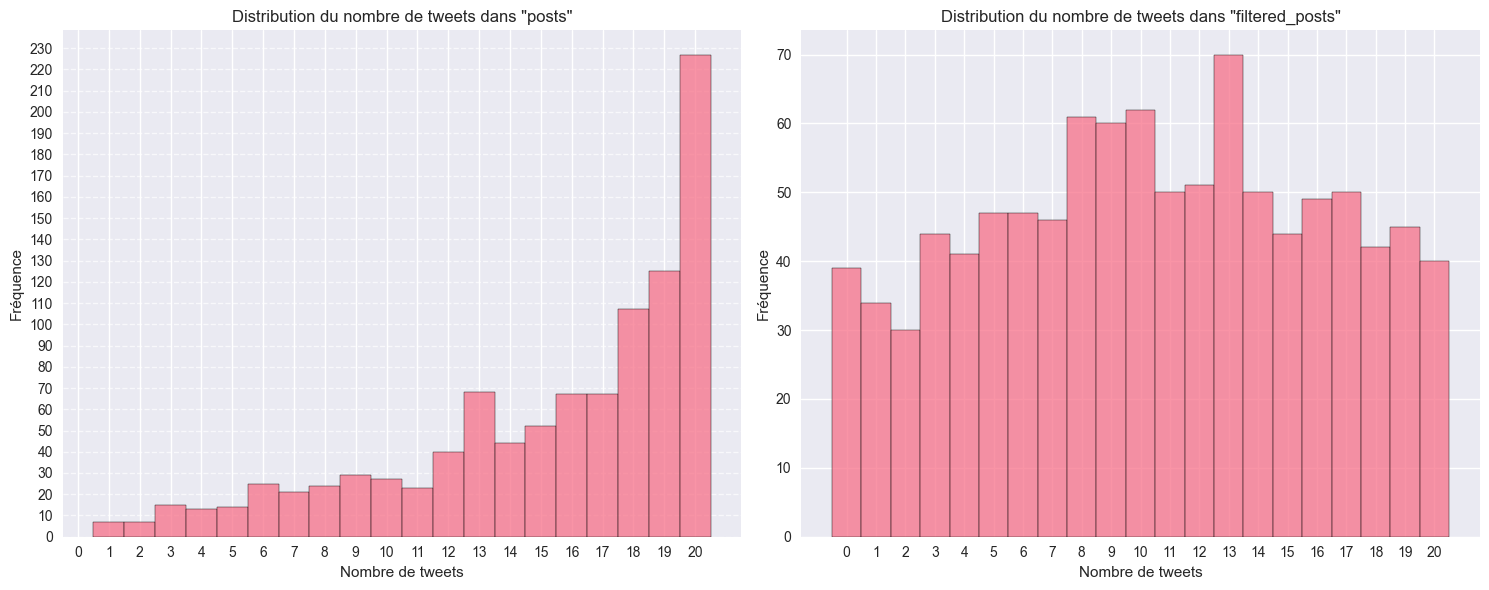

In [519]:
# Déterminer la plage des données pour définir les bins
max_count = max(tweet_counts_original.max(), tweet_counts_filtered.max())
bins = np.arange(-0.5, max_count + 1.5, 1)  # Bins centrés sur les entiers

# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogramme pour les posts initiaux
sns.histplot(tweet_counts_original, bins=bins, kde=False, ax=axes[0], discrete=True)
axes[0].set_title('Distribution du nombre de tweets dans "posts"')
axes[0].set_xlabel('Nombre de tweets')
axes[0].set_ylabel('Fréquence')
axes[0].set_xticks(np.arange(0, max_count + 1, 1))  # Ticks entiers

# Amélioration de la précision de l'axe vertical
y_max = axes[0].get_ylim()[1]
axes[0].set_yticks(np.arange(0, int(y_max) + 1, 10))  # Ticks entiers pour chaque valeur de fréquence
axes[0].grid(axis='y', linestyle='--', alpha=0.7)  # Ajouter une grille horizontale

# Histogramme pour les posts filtrés
sns.histplot(tweet_counts_filtered, bins=bins, kde=False, ax=axes[1], discrete=True)
axes[1].set_title('Distribution du nombre de tweets dans "filtered_posts"')
axes[1].set_xlabel('Nombre de tweets')
axes[1].set_ylabel('Fréquence')
axes[1].set_xticks(np.arange(0, max_count + 1, 1))  # Ticks entiers

# Si le max_count est grand, limitons les ticks pour éviter l'encombrement
if max_count > 20:
    for ax in axes:
        ax.set_xticks(np.arange(0, max_count + 1, 2))  # Ticks tous les 2 entiers

plt.tight_layout()
plt.show()

In [520]:
# Statistiques descriptives
stats_df = pd.DataFrame({
    'Posts originaux': tweet_counts_original.describe(),
    'Posts filtrés': tweet_counts_filtered.describe()
})
print("Statistiques sur le nombre de tweets par entrée:")
display(stats_df)

# Calculer la réduction moyenne du nombre de tweets après filtrage
reduction = ((tweet_counts_original - tweet_counts_filtered) / tweet_counts_original * 100).mean()
print(f"Réduction moyenne du nombre de tweets après filtrage: {reduction:.2f}%")

Statistiques sur le nombre de tweets par entrée:


,Posts originaux,Posts filtrés
count,1002.000000,1002.000000
mean,15.242515,10.333333
std,4.887349,5.660267
min,1.000000,0.000000
25%,13.000000,6.000000
50%,17.000000,10.000000
75%,19.000000,15.000000
max,20.000000,20.000000


Réduction moyenne du nombre de tweets après filtrage: 32.76%


In [521]:
# Remove all row with tweet_counts_filtered = 0
df_filtered = df_filtered[df_filtered['tweet_counts_filtered'] > 0].reset_index(drop=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     963 non-null    int64 
 1   name                   963 non-null    object
 2   screen_name            963 non-null    object
 3   description            959 non-null    object
 4   is_blue_verified       963 non-null    int64 
 5   followers_count        963 non-null    int64 
 6   following_count        963 non-null    int64 
 7   posts_count            963 non-null    int64 
 8   posts                  963 non-null    object
 9   created_at             963 non-null    object
 10  market_cap_rank        963 non-null    int64 
 11  filtered_posts         963 non-null    object
 12  tweet_counts_original  963 non-null    int64 
 13  tweet_counts_filtered  963 non-null    int64 
dtypes: int64(8), object(6)
memory usage: 105.5+ KB


# Normalisation des données par followers (feature engineering)
 Indication sur la qualité de l'engagement d'un compte sur sa communauté.

In [522]:
def calculate_normalized_metric(posts, metric_name, followers_count):
    """
    Calculates the average of a given metric per post, and then normalizes
    it by the number of followers.
    """
    # 1. Handle cases with no posts or no followers to avoid errors
    if not posts or not followers_count or followers_count == 0:
        return 0

    # 2. Calculate the total for the given metric (e.g., total likes)
    total_metric_value = sum(post.get(metric_name, 0) for post in posts.values())

    # 3. Calculate the average per post
    avg_per_post = total_metric_value / len(posts)

    # 4. Normalize by the number of followers
    normalized_value = avg_per_post / followers_count
    return normalized_value

# Create the new normalized feature columns
df_filtered['likes_per_follower'] = df_filtered.apply(
    lambda row: calculate_normalized_metric(row['filtered_posts'], 'likes_count', row['followers_count']),
    axis=1
)
df_filtered['retweets_per_follower'] = df_filtered.apply(
    lambda row: calculate_normalized_metric(row['filtered_posts'], 'retweet_count', row['followers_count']),
    axis=1
)
df_filtered['replies_per_follower'] = df_filtered.apply(
    lambda row: calculate_normalized_metric(row['filtered_posts'], 'reply_count', row['followers_count']),
    axis=1
)
df_filtered['views_per_follower'] = df_filtered.apply(
    lambda row: calculate_normalized_metric(row['filtered_posts'], 'views_count', row['followers_count']),
    axis=1
)
#df_filtered

       likes_per_follower  retweets_per_follower  replies_per_follower  \
count          963.000000             963.000000            963.000000   
mean             0.002923               0.000885              0.001223   
std              0.007288               0.003744              0.012993   
min              0.000012               0.000000              0.000000   
25%              0.000263               0.000049              0.000038   
50%              0.000737               0.000156              0.000117   
75%              0.002476               0.000574              0.000389   
max              0.095890               0.087747              0.369863   

       views_per_follower  
count          963.000000  
mean             0.346285  
std              1.850743  
min              0.000827  
25%              0.020803  
50%              0.054409  
75%              0.161173  
max             37.493151  


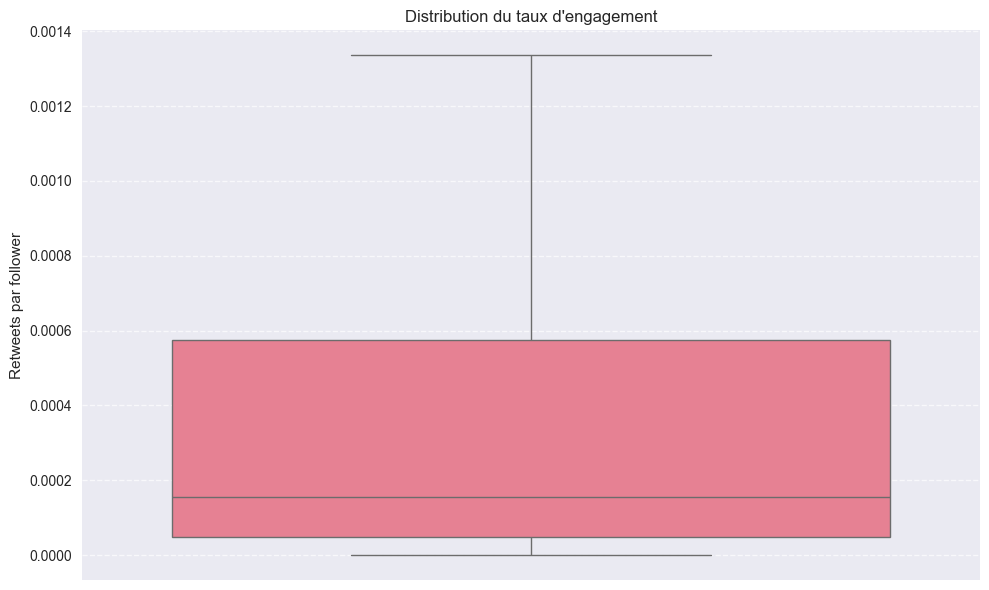

In [523]:
print(
    pd.concat([
        df_filtered['likes_per_follower'].describe(),
        df_filtered['retweets_per_follower'].describe(),
        df_filtered['replies_per_follower'].describe(),
        df_filtered['views_per_follower'].describe()
    ], axis=1)
)

# Création d'un box plot pour visualiser la distribution du taux d'engagement
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_filtered['retweets_per_follower'], showfliers=False)
plt.title('Distribution du taux d\'engagement')
#plt.yscale('log')
plt.ylabel('Retweets par follower')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Afficher les 5 comptes avec le plus haut taux d'engagement
# print("\nTop 5 des comptes avec le plus haut taux d'engagement:")
# top_engagement = df_features.nlargest(5, 'engagement_rate')[['screen_name', 'followers_count', 'engagement_rate', 'likes_rate', 'retweets_rate', 'comments_rate']]
# print(top_engagement)

# Afficher la ligne avec le taux d'engagement le plus élevé
# print("\nCompte avec le taux d'engagement le plus élevé:")
# highest_engagement = df_features.loc[df_features['avg_retweets'].idxmax()]
# print(f"Nom du compte: {highest_engagement['screen_name']}")
# print(f"Nombre de followers: {highest_engagement['followers_count']}")
# print(f"Taux d'engagement: {highest_engagement['avg_retweets']:.4f}")

# Normalisation des données par vues
Indique comment le contenu engage les gens qui ont vu le post.

In [524]:
def calculate_view_normalized_metric(posts, metric_name):
    """
    Calculates the rate of a metric relative to the total number of views.
    """
    if not posts:
        return 0
    
    total_metric = sum(post.get(metric_name, 0) for post in posts.values())
    total_views = sum(post.get('views_count', 0) for post in posts.values())
    
    if total_views == 0:
        return 0
    
    return total_metric / total_views
    
# Create the new view-normalized feature columns
df_filtered['likes_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'likes_count'))
df_filtered['retweets_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'retweet_count'))
df_filtered['replies_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'reply_count'))
#df_filtered

# 2. FEATURE ENGINEERING

# Remove outliers (by views)

In [525]:
def remove_outliers(df_iqr, columns, lower_quantile=0.25, upper_quantile=0.75):
    # Calculer les quantiles sur les colonnes spécifiées
    Q1 = df_iqr[columns].quantile(lower_quantile)
    Q3 = df_iqr[columns].quantile(upper_quantile)
    IQR = Q3 - Q1
    
    # Créer le masque d'outliers en s'assurant de l'alignement
    subset_df = df_iqr[columns]  # Extraire uniquement les colonnes d'intérêt
    
    # Conditions d'outliers alignées
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifier les outliers (vectorisé et aligné)
    is_outlier = ((subset_df < lower_bound) | (subset_df > upper_bound)).any(axis=1)
    
    # Supprimer les outliers du DataFrame complet
    df_clean_iqr = df_iqr[~is_outlier].reset_index(drop=True)
    
    print(f"Nombre d'outliers détectés (IQR): {is_outlier.sum()}")
    print(f"Dataset nettoyé: {len(df_clean_iqr)} lignes sur {len(df_iqr)} originales")
    
    return df_clean_iqr

# Remove outliers from engagement_rate
df_clean_iqr = remove_outliers(df_filtered, [
    'likes_per_views',
    'retweets_per_views',
    'replies_per_views'])

# plt.figure(figsize=(10, 6))
# sns.boxplot(y=df_clean_iqr['likes_per_views'])
# plt.title('Distribution des likes par vues')
# plt.ylabel('Likes per views')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()


Nombre d'outliers détectés (IQR): 137
Dataset nettoyé: 826 lignes sur 963 originales


# Remove outliers (by followers)

In [526]:
def remove_outliers(df_iqr, columns, lower_quantile=0.25, upper_quantile=0.75):
    # Calculer les quantiles sur les colonnes spécifiées
    Q1 = df_iqr[columns].quantile(lower_quantile)
    Q3 = df_iqr[columns].quantile(upper_quantile)
    IQR = Q3 - Q1
    
    # Créer le masque d'outliers en s'assurant de l'alignement
    subset_df = df_iqr[columns]  # Extraire uniquement les colonnes d'intérêt
    
    # Conditions d'outliers alignées
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifier les outliers (vectorisé et aligné)
    is_outlier = ((subset_df < lower_bound) | (subset_df > upper_bound)).any(axis=1)
    
    # Supprimer les outliers du DataFrame complet
    df_clean_iqr = df_iqr[~is_outlier].reset_index(drop=True)
    
    print(f"Nombre d'outliers détectés (IQR): {is_outlier.sum()}")
    print(f"Dataset nettoyé: {len(df_clean_iqr)} lignes sur {len(df_iqr)} originales")
    
    return df_clean_iqr

# Remove outliers from engagement_rate
# df_clean_iqr = remove_outliers(df_filtered, [
#     'likes_per_follower',
#     'retweets_per_follower',
#     'replies_per_follower',
#     'views_per_follower'])

# plt.figure(figsize=(10, 6))
# sns.boxplot(y=df_clean_iqr['likes_per_views'])
# plt.title('Distribution des likes par vues')
# plt.ylabel('Likes per views')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()


# Sélection des features pour le clustering

In [527]:
df_features = df_clean_iqr.copy()
features = [
    #'followers_count',
    #'following_count',
    # 'posts_count',
    # 'market_cap_rank',    
    # 'tweet_counts_filtered',
    # 'likes_per_follower',
    # 'retweets_per_follower',
    # 'replies_per_follower',
    # 'views_per_follower',
    'likes_per_views',
    'retweets_per_views',
    'replies_per_views'
]

print("\n📈 Features d'engagement créées:")
print(df_features[features].describe())


📈 Features d'engagement créées:
       likes_per_views  retweets_per_views  replies_per_views
count       826.000000          826.000000         826.000000
mean          0.013839            0.002997           0.002220
std           0.008756            0.002518           0.001622
min           0.000160            0.000000           0.000000
25%           0.007450            0.001185           0.001022
50%           0.012137            0.002204           0.001780
75%           0.018652            0.004005           0.003027
max           0.043334            0.011751           0.007634


# Extraire les caractéristiques

In [528]:
X = df_features[features]

# Standardisation des features

In [529]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering DBScan

                      id             name      screen_name  \
0              357312062          Bitcoin          Bitcoin   
1             2312333412         Ethereum         ethereum   
2             2893133450           Tether        Tether_to   
3             1051053836           Ripple           Ripple   
4    1052454006537314300        BNB Chain         BNBCHAIN   
..                   ...              ...              ...   
821  1773536509754540000             MEOW  meowmeowcatclub   
822  1779519551685984300  Function | FBTC      FunctionBTC   
823  1787773163209732000   Lombard | LBTC  Lombard_Finance   
824  1859490326316187600          G.A.M.E    GAME_Virtuals   
825  1879171462487019500       loopedHYPE      Looped_HYPE   

                                           description  is_blue_verified  \
0    Bitcoin is an open source censorship-resistant...                 1   
1    The universal platform for crypto, blockchain ...                 1   
2    Finance | Power | Data

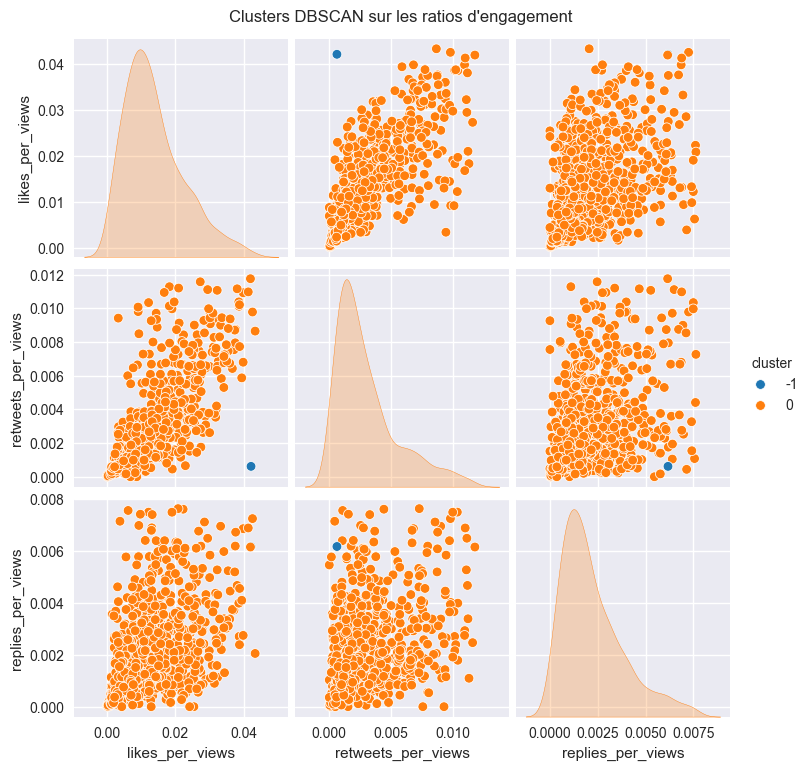

In [530]:
dbscan = DBSCAN(eps=1.2, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)

# Ajout des clusters au dataframe
df_features['cluster'] = clusters

# Affichage
print(df_features)

# Visualisation (2D avec pairs)
sns.pairplot(df_features[features + ['cluster']], hue='cluster', palette='tab10')
plt.suptitle("Clusters DBSCAN sur les ratios d'engagement", y=1.02)
plt.show()

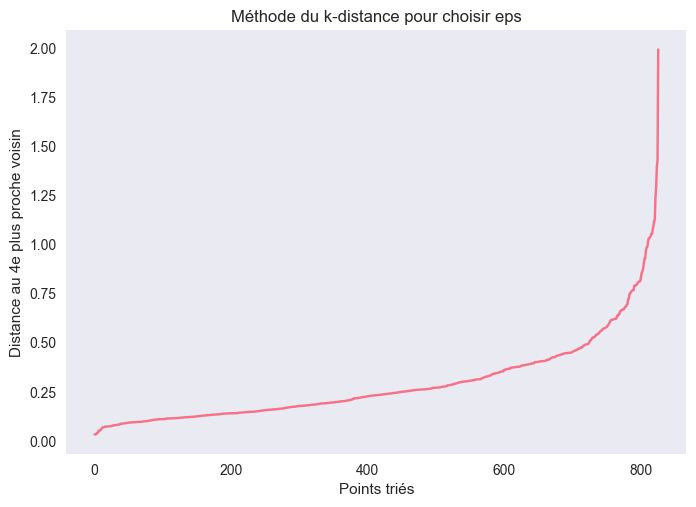

In [531]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, 3])  # 3 = k - 1

plt.plot(distances)
plt.title("Méthode du k-distance pour choisir eps")
plt.xlabel("Points triés")
plt.ylabel("Distance au 4e plus proche voisin")
plt.grid()
plt.show()


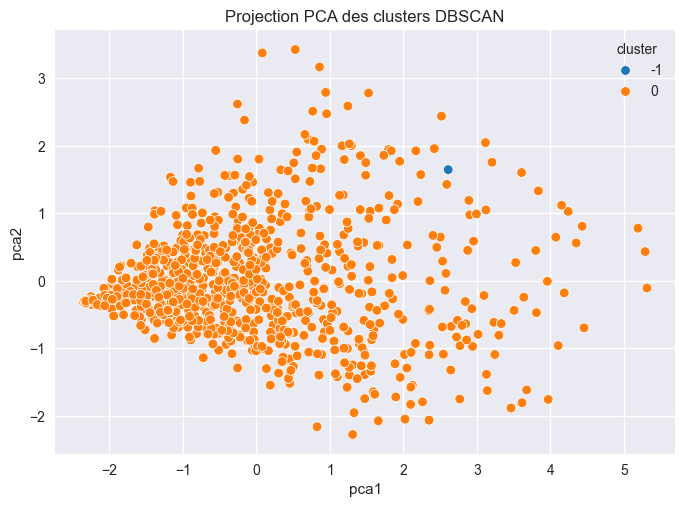

In [532]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_features['pca1'], df_features['pca2'] = X_pca[:,0], X_pca[:,1]

sns.scatterplot(data=df_features, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title("Projection PCA des clusters DBSCAN")
plt.show()


# Clustering KMeans

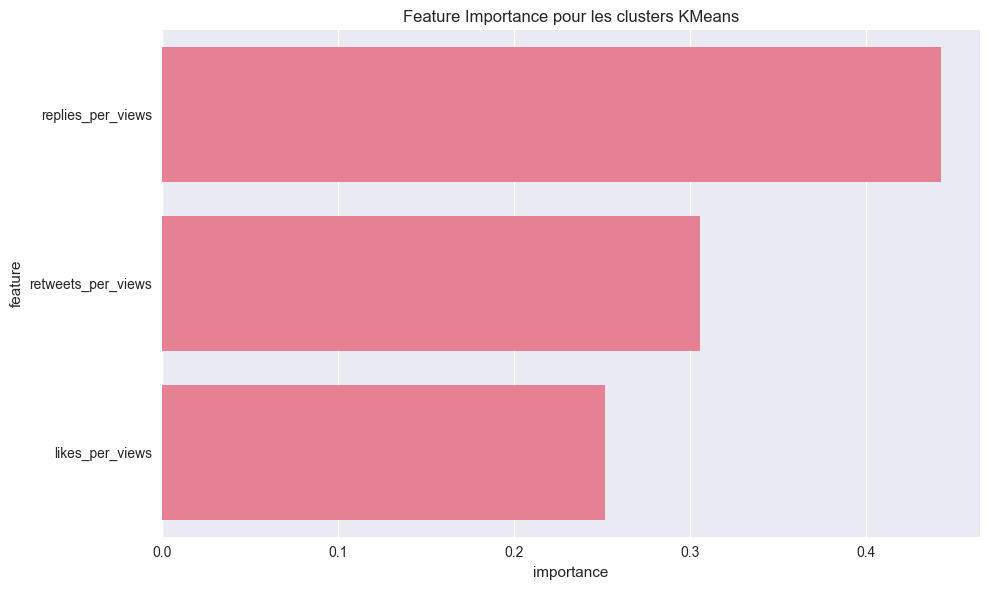

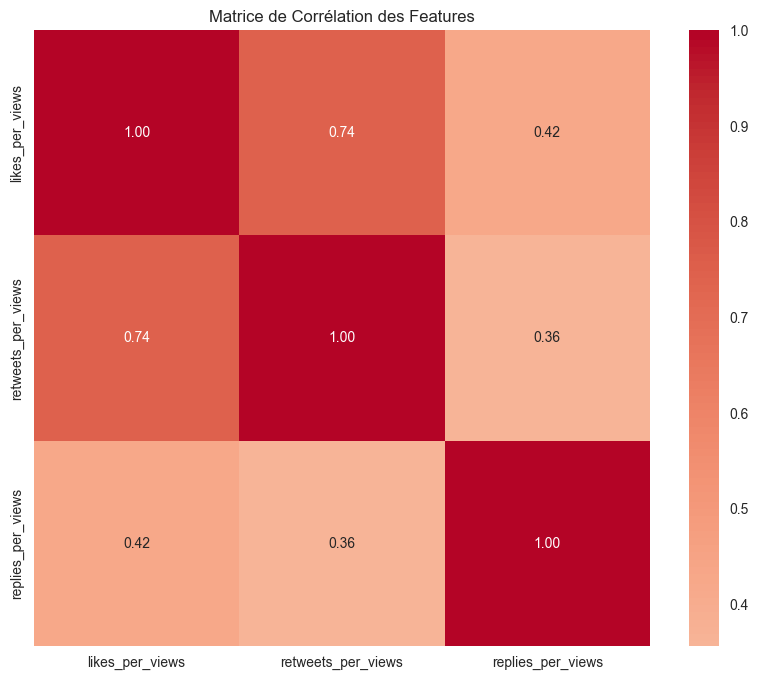

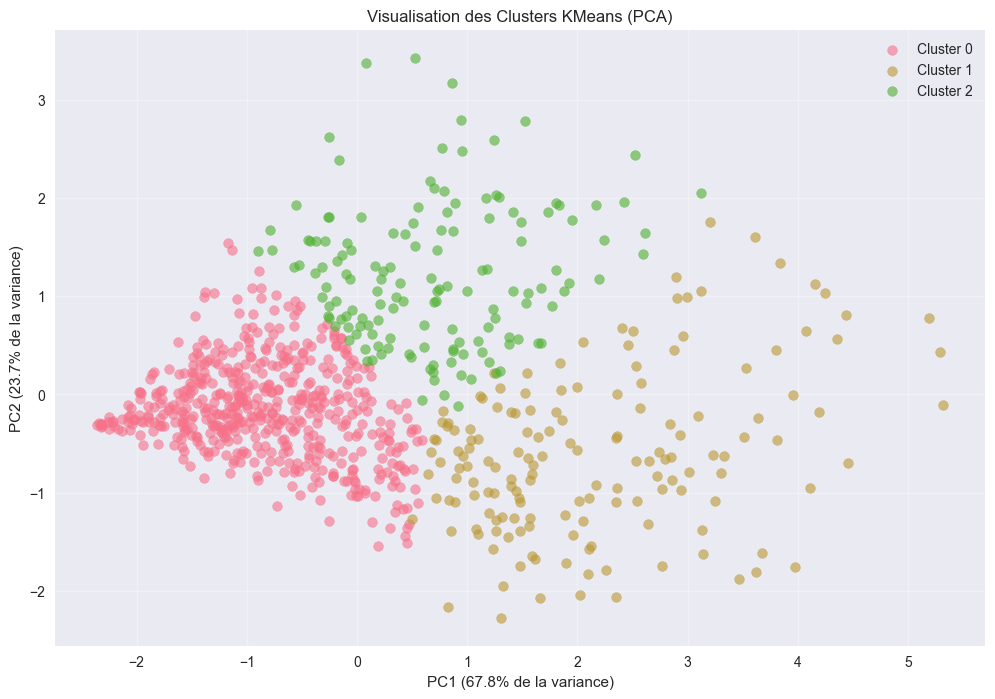

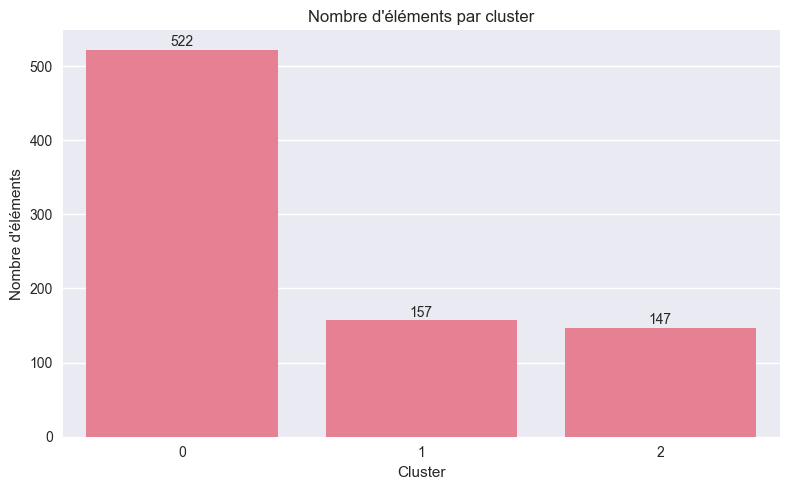

In [533]:
# Extraire les caractéristiques
X = df_features[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Effectuer le clustering KMeans
n_clusters = 3
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(X_scaled)

# Ajouter les clusters au DataFrame original
df_features["cluster"] = cluster_labels

# Calculer l'importance des features via RandomForest sur les clusters
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_scaled, cluster_labels)
importances_f = rf_model.feature_importances_

# Créer un DataFrame pour visualiser l'importance des features
feature_importance_df = pd.DataFrame({
    "feature": features,
    "importance": importances_f
}).sort_values(by="importance", ascending=False)

# Visualiser l'importance des features
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance_df)
plt.title("Feature Importance pour les clusters KMeans")
plt.tight_layout()
plt.show()

# Matrice de corrélation
plt.figure(figsize=(10, 8))
correlation_matrix = df_features[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Matrice de Corrélation des Features')
plt.show()

# Visualiser les clusters avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    mask = df_features['cluster'] == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               label=f'Cluster {i}', alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} de la variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} de la variance)')
plt.title('Visualisation des Clusters KMeans (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Afficher le nombre d'éléments dans chaque cluster
cluster_counts = df_features['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Nombre d\'éléments par cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre d\'éléments')
plt.xticks(range(n_clusters))
for i, count in enumerate(cluster_counts.values):
    plt.text(i, count + 5, str(count), ha='center')
plt.tight_layout()
plt.show()

# Distribution des niveaux d'engagement
# plt.figure(figsize=(10, 6))
# engagement_counts = df_features['engagement_level'].value_counts()
# colors_pie = ['#ff9999', '#66b3ff', '#99ff99']
# plt.pie(engagement_counts.values, labels=engagement_counts.index, 
#         autopct='%1.1f%%', colors=colors_pie, startangle=90)
# plt.title('Distribution des Niveaux d\'Engagement')
# plt.show()


# 3. EXPLORATION DES DONNÉES

# 4. DÉTERMINATION DU NOMBRE OPTIMAL DE CLUSTERS

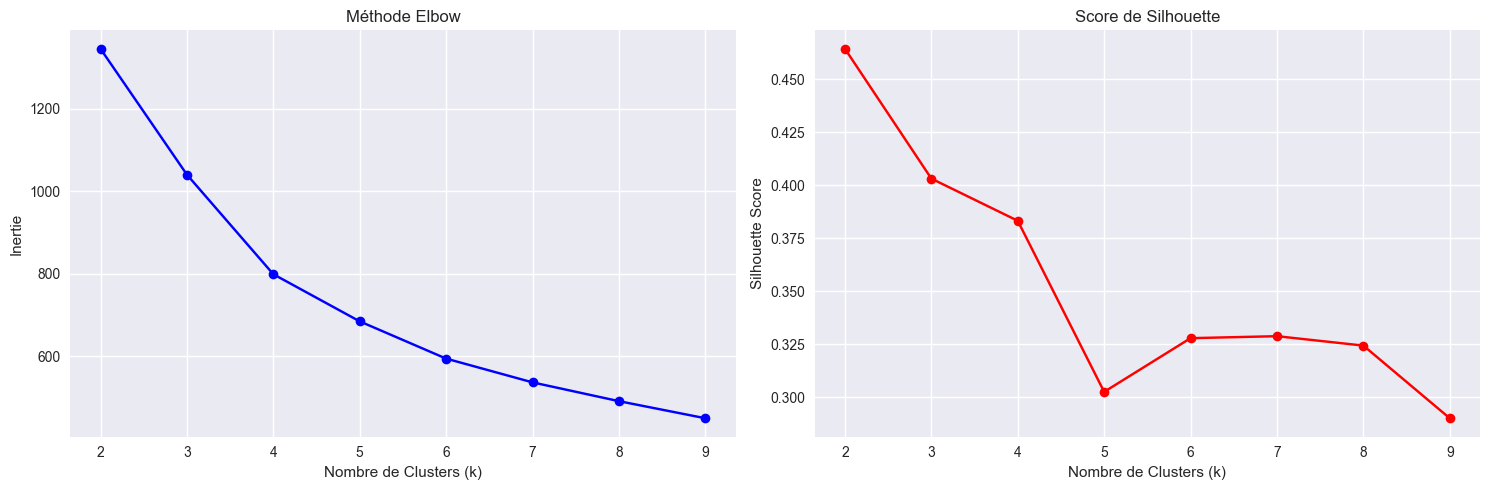

📊 Scores de Silhouette par nombre de clusters:
k=2: 0.464
k=3: 0.403
k=4: 0.383
k=5: 0.303
k=6: 0.328
k=7: 0.329
k=8: 0.324
k=9: 0.290


In [534]:
# Préparation des données
X = df_features[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Méthode Elbow
inertias = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Nombre de Clusters (k)')
ax1.set_ylabel('Inertie')
ax1.set_title('Méthode Elbow')
ax1.grid(True)

# Silhouette Score
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Nombre de Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Score de Silhouette')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("📊 Scores de Silhouette par nombre de clusters:")
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.3f}")

# 5. CLUSTERING K-MEANS

In [535]:
# Clustering avec k=3 (Fort, Moyen, Faible)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Ajout des labels au dataset
df_features['cluster'] = cluster_labels

# Analyse des clusters
print(f"\n🎯 Résultats du clustering (k={optimal_k}):")
print(f"Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")

cluster_summary = df_features.groupby('cluster')[features].mean()
print("\n📋 Profil moyen des clusters:")
cluster_summary



🎯 Résultats du clustering (k=3):
Silhouette Score: 0.403

📋 Profil moyen des clusters:


,likes_per_views,retweets_per_views,replies_per_views
cluster,,,
0,0.009682,0.001835,0.001359
1,0.026449,0.007099,0.003004
2,0.015133,0.002744,0.004444


In [536]:
#df_features.head()
# Find all rows where cluster == 2
display(df_features[df_features['cluster'] == 2][['screen_name', 'cluster']].head())

# Find all rows where cluster == 1
display(df_features[df_features['cluster'] == 1][['screen_name', 'cluster']].head())

# Find all rows where cluster == 0
display(df_features[df_features['cluster'] == 0][['screen_name', 'cluster']].head())

display(df_features[df_features['name'] == 'Bitcoin'][
    ['screen_name', 'likes_per_views', 'retweets_per_views', 'replies_per_views', 'cluster']
])


,screen_name,cluster
4,BNBCHAIN,2
7,trondao,2
11,SuiNetwork,2
20,bitgetglobal,2
22,Uniswap,2


,screen_name,cluster
18,hedera,1
28,dfinity,1
31,eth_classic,1
47,quant_network,1
51,Stacks,1


,screen_name,cluster
0,Bitcoin,0
1,ethereum,0
2,Tether_to,0
3,Ripple,0
5,solana,0


,screen_name,likes_per_views,retweets_per_views,replies_per_views,cluster
0,Bitcoin,0.009646,0.002686,0.001594,0


# 6. LABÉLISATION DES CLUSTERS et Persona

In [537]:
def assign_engagement_labels(df_clustered):
    """
    Ajoute une colonne 'engagement_level' au DataFrame avec les labels correspondants aux clusters:
    - Cluster 0 → "Faible"
    - Cluster 1 → "Fort" 
    - Cluster 2 → "Moyen"
    """
    # Mapping des clusters vers les labels
    cluster_labels = {
        0: "Faible",
        1: "Fort",
        2: "Moyen"
    }
    
    # Créer une copie du DataFrame pour éviter de modifier l'original
    result_df = df_clustered.copy()
    
    # Ajouter la colonne engagement_level
    result_df['engagement_level'] = result_df['cluster'].map(cluster_labels)
    
    return result_df

df_features = assign_engagement_labels(df_features)

df_features.head()

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,...,retweets_per_follower,replies_per_follower,views_per_follower,likes_per_views,retweets_per_views,replies_per_views,cluster,pca1,pca2,engagement_level
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1937803517265056232"": {""created_at"": ""...",Thu Aug 18 05:06:08 +0000 2011,...,0.000035,0.000021,0.013056,0.009646,0.002686,0.001594,0,-0.560876,-0.161880,Faible
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1937947714920300627"": {""created_at"": ""...",Sun Jan 26 19:15:24 +0000 2014,...,0.000065,0.000042,0.038827,0.009494,0.001682,0.001073,0,-0.968492,-0.282231,Faible
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",Fri Nov 07 21:02:30 +0000 2014,...,0.000049,0.000055,0.072524,0.003922,0.000672,0.000759,0,-1.709525,-0.123050,Faible
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",Mon Dec 31 19:45:39 +0000 2012,...,0.000252,0.000043,0.073751,0.013310,0.003412,0.000577,0,-0.412911,-0.939113,Faible
4,1052454006537314300,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",Wed Oct 17 06:59:23 +0000 2018,...,0.000006,0.000017,0.004128,0.005952,0.001455,0.004204,2,-0.373118,1.558519,Moyen


### Personas

Cluster 0 - "Comptes à Faible Engagement" (Low Engagement Accounts)
Likes/vues : 0.97% (le plus faible)
Retweets/vues : 0.18% (le plus faible)
Réponses/vues : 0.14% (le plus faible)
Persona : Comptes crypto passifs ou dormants

Audience peu engagée ou inactive
Contenu potentiellement de faible qualité ou peu pertinent
Possibles bots, comptes abandonnés, ou projets crypto sans communauté active
Stratégie de contenu inefficace
Cluster 1 - "Comptes à Très Fort Engagement" (High Engagement Accounts)
Likes/vues : 2.64% (le plus élevé)
Retweets/vues : 0.71% (le plus élevé)
Réponses/vues : 0.30% (modéré)
Persona : Influenceurs crypto et projets premium

Communauté très active et loyale
Contenu de haute qualité, analyses pertinentes
Leaders d'opinion dans l'espace crypto
Projets établis avec forte notoriété (Bitcoin, Ethereum, projets majeurs)
Stratégie de contenu optimisée
Cluster 2 - "Comptes Conversationnels" (Discussion-Focused Accounts)
Likes/vues : 1.51% (modéré)
Retweets/vues : 0.27% (modéré)
Réponses/vues : 0.44% (le plus élevé)
Persona : Comptes orientés discussion et communauté

Encourage fortement les conversations et débats
Focus sur l'interaction directe avec la communauté
Possibles comptes éducatifs, d'analyse technique, ou de news crypto
Stratégie axée sur la construction de communauté plutôt que sur la viralité

Insights Stratégiques :
Cluster 1 représente l'élite des comptes crypto avec le meilleur ROI d'engagement
Cluster 2 mise sur l'interaction communautaire - excellent pour la fidélisation
Cluster 0 nécessite une refonte complète de stratégie de contenu

# 8. VALIDATION ET MÉTRIQUES

In [538]:
def validate_clustering(X, labels, cluster_centers=None):
    """Calcule différentes métriques de validation"""
    
    metrics = {
        'silhouette_score': silhouette_score(X, labels),
        'n_clusters': len(np.unique(labels)),
        'samples_per_cluster': np.bincount(labels)
    }
    
    return metrics

validation_metrics = validate_clustering(X_scaled, cluster_labels)

print("\n✅ MÉTRIQUES DE VALIDATION:")
print(f"Score de Silhouette: {validation_metrics['silhouette_score']:.3f}")
print(f"Nombre de clusters: {validation_metrics['n_clusters']}")
print("Répartition des échantillons par cluster:")
for i, count in enumerate(validation_metrics['samples_per_cluster']):
    print(f"  - Cluster {i}: {count} comptes")


✅ MÉTRIQUES DE VALIDATION:
Score de Silhouette: 0.403
Nombre de clusters: 3
Répartition des échantillons par cluster:
  - Cluster 0: 522 comptes
  - Cluster 1: 157 comptes
  - Cluster 2: 147 comptes


# 9. ANALYSE DES COMPTES REPRÉSENTATIFS

In [548]:
print("\n🔍 ANALYSE DES COMPTES REPRÉSENTATIFS:")

for engagement_level in ['Fort', 'Moyen', 'Faible']:
    print(f"\n--- ENGAGEMENT {engagement_level.upper()} ---")
    subset = df_features[df_features['engagement_level'] == engagement_level]
    
    # Statistiques du groupe
    print(f"Nombre de comptes: {len(subset)}")
    print(f"Followers moyen: {subset['followers_count'].mean():.0f}")
    
    # Top 3 comptes du groupe
    top_accounts = subset.nlargest(3, 'cluster')[
        ['screen_name', 'followers_count', 'retweets_per_views', 'replies_per_views', 'likes_per_views']
    ]
    print("Top 3 comptes:")
    print(top_accounts.to_string(index=False))


🔍 ANALYSE DES COMPTES REPRÉSENTATIFS:

--- ENGAGEMENT FORT ---
Nombre de comptes: 157
Followers moyen: 185101
Top 3 comptes:
screen_name  followers_count  retweets_per_views  replies_per_views  likes_per_views
     hedera           443164            0.005720           0.001403         0.026038
    dfinity           683548            0.006058           0.001320         0.027493
eth_classic            26297            0.009801           0.004017         0.009159

--- ENGAGEMENT MOYEN ---
Nombre de comptes: 147
Followers moyen: 399362
Top 3 comptes:
screen_name  followers_count  retweets_per_views  replies_per_views  likes_per_views
   BNBCHAIN          3848162            0.001455           0.004204         0.005952
    trondao          1724484            0.002207           0.004200         0.011878
 SuiNetwork          1103021            0.001474           0.004024         0.009186

--- ENGAGEMENT FAIBLE ---
Nombre de comptes: 522
Followers moyen: 566018
Top 3 comptes:
screen_name  foll

# 10. FONCTION DE PRÉDICTION POUR NOUVEAUX COMPTES

In [ ]:
def predict_engagement_level(new_account, scaler, kmeans_model, engagement_labels):
    """
    Prédit le niveau d'engagement d'un nouveau compte Twitter/X
    
    Parameters:
    -----------
    new_account : dict
        Dictionnaire contenant les métriques du compte
    scaler : sklearn.preprocessing.StandardScaler
        Le scaler utilisé pour normaliser les données
    kmeans_model : sklearn.cluster.KMeans
        Le modèle KMeans entraîné
    engagement_labels : dict
        Dictionnaire de mapping {cluster_id: label}
    """
    # Créer un DataFrame avec les métriques d'engagement directement calculées
    features = {}
    
    # Calculer les ratios d'engagement
    total_views = new_account.get('vues', 0)
    if total_views > 0:
        features['likes_per_views'] = new_account.get('likes', 0) / total_views
        features['retweets_per_views'] = new_account.get('retweets', 0) / total_views
        features['replies_per_views'] = new_account.get('replies', 0) / total_views
    else:
        features['likes_per_views'] = 0
        features['retweets_per_views'] = 0
        features['replies_per_views'] = 0
    
    # Créer un DataFrame avec les features
    feature_df = pd.DataFrame([features])
    
    # Liste des colonnes de features utilisées pour le clustering
    feature_columns = ['likes_per_views', 'retweets_per_views', 'replies_per_views']
    
    # Normalisation des données
    X_new_scaled = scaler.transform(feature_df[feature_columns])
    
    # Prédiction du cluster
    cluster_pred = kmeans_model.predict(X_new_scaled)[0]
    
    # Obtention du label d'engagement
    engagement_pred = engagement_labels[cluster_pred]
    
    return engagement_pred, cluster_pred

# Exemple d'utilisation
nouveau_compte = {
    'nom_compte': 'nouveau_crypto_trader',
    'followers': 25000,
    'following': 1200,
    'likes': 800,
    'retweets': 250,
    'commentaires': 120
}

predicted_engagement, predicted_cluster = predict_engagement_level(
    nouveau_compte, scaler, kmeans, engagement_labels
)

print(f"\n🔮 PRÉDICTION POUR NOUVEAU COMPTE:")
print(f"Compte: {nouveau_compte['nom_compte']}")
print(f"Niveau d'engagement prédit: {predicted_engagement}")
print(f"Cluster assigné: {predicted_cluster}")

print("\n✨ PIPELINE ML TERMINÉ AVEC SUCCÈS!")
print(f"Modèle entraîné sur {len(df_features)} comptes avec {len(features)} features")
print(f"Silhouette Score final: {silhouette_score(X_scaled, cluster_labels):.3f}")

TypeError: unhashable type: 'numpy.ndarray'